In [3]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import os
from os import listdir

# ścieżka do pliku exe OCR, ten cały tesseract musi być zainstalowany wcześniej 
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\wilko\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

class SudokuBoard():
    def __init__(self, n, image):
        self.board_image = image
        self.n = n

        self.BOARD_WIDTH = 2 * image.shape[1]
        self.BOARD_HEIGHT = 2 * image.shape[0]
        
        if n == 3:
            self.cell_size = self.BOARD_HEIGHT // 9
        elif n == 2:
            self.cell_size = self.BOARD_HEIGHT // 4

        self.cell_images = []

        self.process_board_image()
        self.split_board_image()

    def process_board_image(self):
        ''' Zwiększa rozdzielczość screena planszy, usuwa niepotrzebne linie w planszy i konwertuje do obrazu binarnego '''

        resized_board_img = cv2.resize(self.board_image, (self.BOARD_WIDTH, self.BOARD_HEIGHT)) 
        gray_board_img = cv2.cvtColor(resized_board_img, cv2.COLOR_RGB2GRAY)
        _,binary_board_img = cv2.threshold(gray_board_img, 127,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        cv2.line(binary_board_img, (0, 0), (0, self.BOARD_HEIGHT), (255,255,255), 20)
        cv2.line(binary_board_img, (self.BOARD_WIDTH, 0), (self.BOARD_WIDTH, self.BOARD_HEIGHT), (255,255,255), 20)
        cv2.line(binary_board_img, (0, self.BOARD_HEIGHT), (self.BOARD_WIDTH, self.BOARD_HEIGHT), (255,255,255), 20)
        cv2.line(binary_board_img, (0, 0), (self.BOARD_WIDTH, 0), (255,255,255), 20)

        if self.n == 3:
            line_coord_x = self.BOARD_WIDTH // 3
            line_coord_y = self.BOARD_HEIGHT // 3

            cv2.line(binary_board_img, (0,line_coord_y), (self.BOARD_WIDTH, line_coord_y), (255,255,255), 20)
            cv2.line(binary_board_img, (0,line_coord_y*2),(self.BOARD_WIDTH, line_coord_y*2),(255,255,255), 20)

            cv2.line(binary_board_img, (line_coord_x,0), (line_coord_x, self.BOARD_HEIGHT), (255,255,255), 20)
            cv2.line(binary_board_img, (line_coord_x*2,0), (line_coord_x*2, self.BOARD_HEIGHT), (255,255,255), 20)
        
        elif self.n == 2:
            line_coord_x = self.BOARD_WIDTH // 2
            line_coord_y = self.BOARD_HEIGHT // 2

            cv2.line(binary_board_img, (0,line_coord_y), (self.BOARD_WIDTH, line_coord_y), (255,255,255), 20)
            cv2.line(binary_board_img, (line_coord_x,0), (line_coord_x, self.BOARD_HEIGHT), (255,255,255), 20)


        self.processed_board_image = binary_board_img
    
    def split_board_image(self):
        ''' Dzieli plansze na 81 pól tak żeby OCR na każdym był w stanie wykryć cyfrę '''

        y_start = 0
        x_start = 0
        if self.n == 3:
            y_end = self.BOARD_HEIGHT // 9
            x_end = self.BOARD_WIDTH // 9

        elif self.n == 2:
            y_end = self.BOARD_HEIGHT // 4
            x_end = self.BOARD_WIDTH // 4

        for i in range(1, self.n * self.n + 1):
            for j in range(1,self.n * self.n + 1):
                self.cell_images.append(self.processed_board_image[y_start : y_end, x_start : x_end])
                x_start += self.cell_size
                x_end += self.cell_size
            
            x_start = 0
            x_end = self.cell_size

            y_start += self.cell_size
            y_end += self.cell_size
    
    def create_board(self):
        ''' OCR wykrywa cyfry z poszczególnych komórek planszy, w pustych polach wstawione są 0, funkcja zwraca macierz numpy 9x9,'''
        
        board = []

        for image in self.cell_images:
            ocr_result = pytesseract.image_to_string(image, config='--psm 13 --oem 3 -c tessedit_char_whitelist=123456789')
            if ocr_result != '':
                board.append(int(ocr_result))
            else: 
                board.append(0)

        board = np.array(board)

        if self.n == 3:
            board = board.reshape((9,9))

        elif self.n == 2:
            board = board.reshape((4,4))

        return board

In [2]:
board_img = cv2.imread(r"C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Pierdoly\ocr_test.PNG")

In [6]:
folder_dir = r"C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Pierdoly\training_data\board_images"
resized_images = []
for images in os.listdir(folder_dir):
        if (images.endswith(".png")):
            board_img = cv2.imread(f'{folder_dir}\{images}')
            sudoku_board = SudokuBoard(3, board_img)
            for cell in sudoku_board.cell_images:
                cell = cv2.resize(cell, (64,64))
                resized_images.append(cell)

In [12]:
len(resized_images)

5184

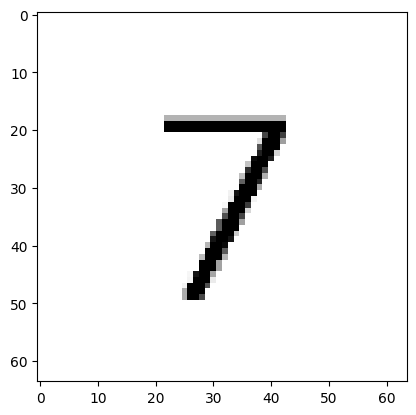

In [10]:
plt.imshow(resized_images[0], cmap='gray')

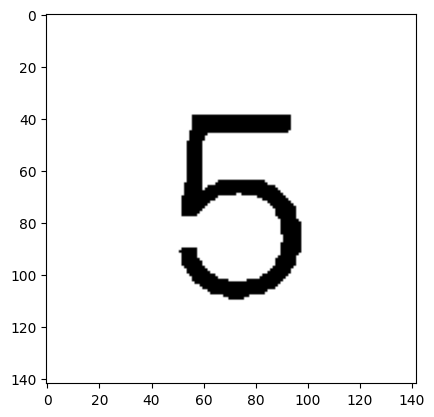

In [39]:
plt.imshow(sudoku_board.cell_images[0], cmap='gray')

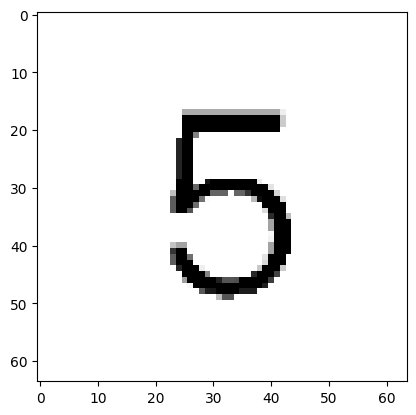

In [56]:
plt.imshow(resized_images[1], cmap='gray')

In [13]:

img_num=0
for image in resized_images:
    ocr_result = pytesseract.image_to_string(image, config='--psm 13 --oem 3 -c tessedit_char_whitelist=123456789')

    if ocr_result != '':
        cv2.imwrite(fr'C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Pierdoly\training_data\{int(ocr_result)}\{img_num}.png', image)
    else: 
        cv2.imwrite(fr'C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Pierdoly\training_data\0\{img_num}.png', image)

    img_num+=1

In [51]:
for i in range (0,10):
    train_data = []
    folder_dir = rf"C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Pierdoly\training_data\{i}"

    for images in os.listdir(folder_dir):
            if (images.endswith(".png")):
                img = cv2.imread(f'{folder_dir}\{images}', cv2.IMREAD_GRAYSCALE)
                train_data.append(img)

    with open(f'{i}_data.npy', 'wb') as f:
        np.save(f, train_data)

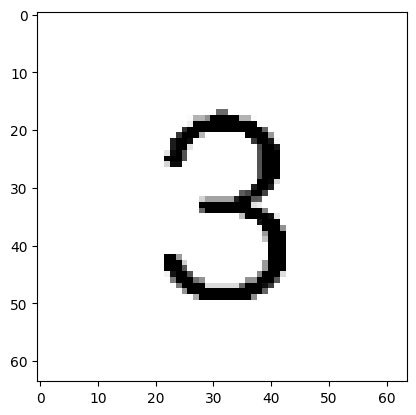

In [52]:
plt.imshow(train_data[0], cmap='gray')

In [53]:
train_data[0].shape

(64, 64)

# Test wytrenowanej OCR'ki

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
model = keras.models.load_model(r"C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Models\sudoku_ocr.h5")

In [15]:
board_img = cv2.imread(r'C:\Users\wilko\Desktop\Studia\Projekty studia\Optymalizacja dyskretna - Sudoku\Dane\Pierdoly\training_data\board_images\model_test.PNG')

In [16]:
sudoku_board = SudokuBoard(3, board_img)

In [17]:
sudoku_board.process_board_image()
sudoku_board.split_board_image()

In [18]:
sudoku_board.cell_images[0].shape

(111, 111)

In [36]:
resized_images = []
for cell in sudoku_board.cell_images:
    cell = cv2.resize(cell, (64,64))
    resized_images.append(cell)

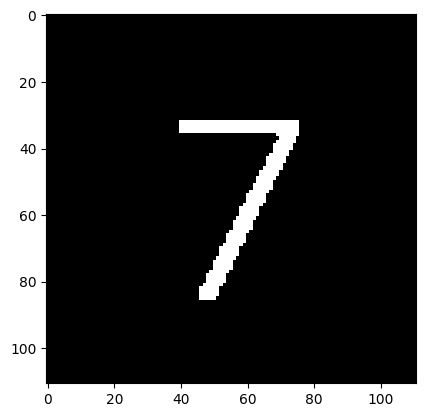

In [38]:
plt.imshow(sudoku_board.cell_images[0], cmap='binary')

In [24]:
resized_images[0].shape

(1, 64, 64, 1)

In [39]:
model.predict(resized_images[0])

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_3/conv2d_15/Relu' defined at (most recent call last):
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\wilko\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\wilko\AppData\Local\Temp\ipykernel_5612\2985810943.py", line 1, in <module>
      model.predict(resized_images[0])
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_3/conv2d_15/Relu'
convolution input must be 4-dimensional: [32,64]
	 [[{{node sequential_3/conv2d_15/Relu}}]] [Op:__inference_predict_function_1315]